# CRIANDO A REDE NEURAL

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [47]:
# Link do Colab com o Drive
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf  # Biblioteca para criar a rede neural
from tensorflow import keras
from keras import callbacks
from keras import layers
from keras import regularizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt  # Para visualizar imagens
import numpy as np  # Para manipulação de arrays
import os  # Para trabalhar com diretórios
from sklearn.model_selection import train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Found 1311 files belonging to 4 classes.
Training the model...
Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.4735 - loss: 1.8022 - precision: 0.7311 - recall: 0.2088
Epoch 1: val_loss improved from inf to 0.78398, saving model to /content/drive/MyDrive/PROJETO IA 2024-2025/modelos_salvos/melhor_modelo_tumores_sem_VC.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 25s 158ms/step - accuracy: 0.4745 - loss: 1.7989 - precision: 0.7313 - recall: 0.2103 - val_accuracy: 0.7769 - val_loss: 0.7840 - val_precision: 0.8203 - val_recall: 0.7069 - learning_rate: 0.0010
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7631 - loss: 0.7968 - precision: 0.7990 - recall: 0.6995
Epoch 2: val_loss improved from 0.78398 to 0.62973, saving model to /content/drive/MyDrive/PROJETO IA 2024-2025/modelos_salvos/melhor_modelo_tumores_sem_VC.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - accuracy: 0.7632 - loss: 0.7966 - precision: 0.7990 - recall: 0.6996 - val_accuracy: 0.8381 - v

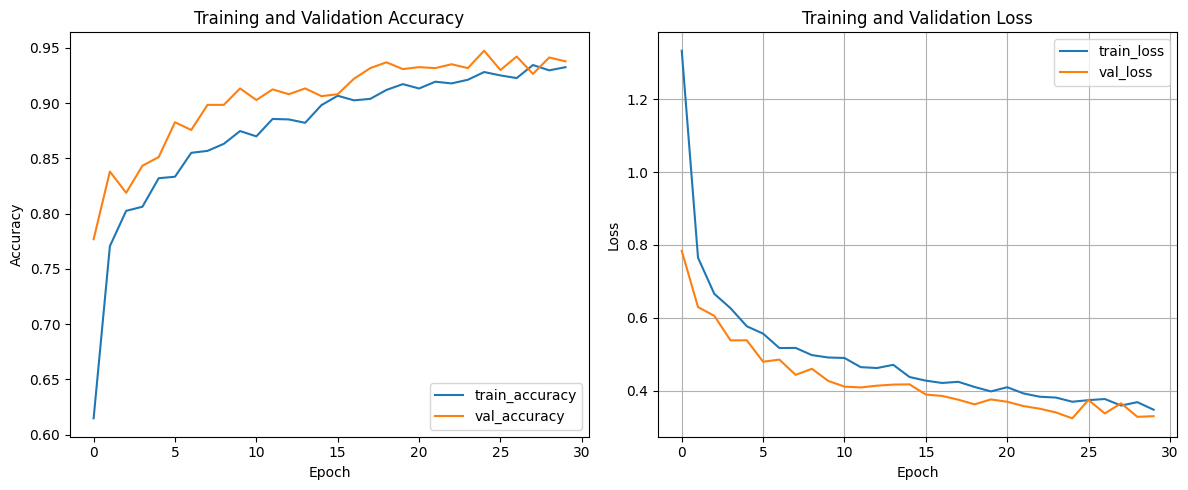


Avaliação do modelo final no conjunto de teste:
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9116 - loss: 0.4095 - precision: 0.9165 - recall: 0.9096
Loss no teste: 0.3653
Acurácia no teste: 0.9314
Precisão no teste: 0.9383
Recall no teste: 0.9283
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step


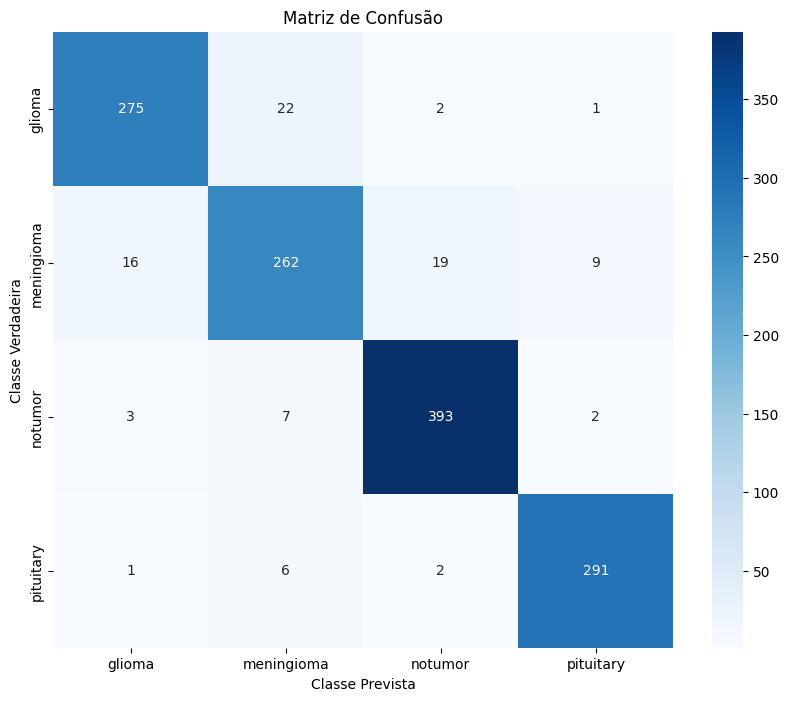

In [61]:
# Definir o caminho do dataset
dataset_path = "/kaggle/input/brain-tumor-mri-dataset"
train_dir = os.path.join(dataset_path, "Training")
test_dir = os.path.join(dataset_path, "Testing")

# Definir o novo tamanho da imagem
IMAGE_SIZE = (64, 64)

# Coletar caminhos de imagem e rótulos do conjunto de treinamento
image_paths = []
labels = []
class_names_list = sorted(os.listdir(train_dir))
num_classes = len(class_names_list)
class_to_label = {name: i for i, name in enumerate(class_names_list)}

for class_name in class_names_list:
    class_dir = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_name))
        labels.append(class_to_label[class_name])

# Converter para numpy arrays
image_paths = np.array(image_paths)
labels = np.array(labels)

# Dividir o conjunto de treino em treino e validação
# Usando 80% para treino e 20% para validação (ajustável)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# Carregar o conjunto de teste separadamente
test_dataset_raw = keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMAGE_SIZE,
    batch_size=32, # Ajustar o tamanho do batch
    shuffle=False,
    label_mode='categorical') # São mais de 2 classes, então é categorical

# Pegar os nomes das classes ANTES de otimizar o dataset
class_names = test_dataset_raw.class_names

# Otimização de desempenho para o conjunto de teste
AUTOTUNE = tf.data.AUTOTUNE
test_dataset = test_dataset_raw.cache().prefetch(buffer_size=AUTOTUNE)

# Data Augmentation (opcional)
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"), # Inversão horizontal
        layers.RandomRotation(0.05),       # Rotação para até 5% (0.05 radianos)
        layers.RandomContrast(0.05),     # Ajuste de contraste (opcional)
    ],
    name="data_augmentation",
)

# Função para criar o modelo
def create_model(num_classes):
    model = keras.Sequential([
        keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        layers.Rescaling(1./255),
        layers.Conv2D(16, (3,3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2), strides=2),
        layers.Dropout(0.3),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2), strides=2),
        layers.Dropout(0.2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2), strides=2),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        loss="categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=["accuracy",
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')])
    return model

# Função para criar datasets de treino e validação a partir de caminhos e rótulos
# Para usar o Data Augmentation: augment=True
def create_tf_dataset_split(image_paths, labels, num_classes, batch_size, shuffle=False, augment=False):
    # Função auxiliar para carregar e pré-processar imagens
    def load_image(image_path, label):
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMAGE_SIZE)
        label = tf.one_hot(label, num_classes)
        return img, label

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.map(lambda x, y: load_image(x, y), num_parallel_calls=AUTOTUNE)
    if augment:
         dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE) # Aplica DA no treino
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
    return dataset

# Criar datasets de treino e validação
# Para usar o Data Augmentation: augment=True
train_dataset = create_tf_dataset_split(train_paths, train_labels, num_classes, batch_size=32, shuffle=True, augment=False)
val_dataset = create_tf_dataset_split(val_paths, val_labels, num_classes, batch_size=32)


# Criação e compilação do modelo final
model = create_model(num_classes)

# Early Stopping e Learning Rate para o treinamento
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001
)

# Callback para salvar o melhor modelo
model_checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/PROJETO IA 2024-2025/modelos_salvos/melhor_modelo_tumores_sem_VC.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

print("Training the model...")
history = model.fit(
    train_dataset,
    epochs=50, # Número de épocas
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr, model_checkpoint_callback])

# Plotagem dos resultados do treinamento
plt.figure(figsize=(12, 5))

# Plotar Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')

# Plotar Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Avaliação do modelo final no conjunto de teste
print("\nAvaliação do modelo final no conjunto de teste:")
loss, accuracy, precision, recall = model.evaluate(test_dataset)
print(f"Loss no teste: {loss:.4f}")
print(f"Acurácia no teste: {accuracy:.4f}")
print(f"Precisão no teste: {precision:.4f}")
print(f"Recall no teste: {recall:.4f}")

# Geração da Matriz de Confusão
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Fazer previsões no conjunto de teste
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Obter os rótulos verdadeiros do conjunto de teste
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
# Converter os rótulos de one-hot para um único número
y_true = np.argmax(y_true, axis=1)

# 3. Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)

# 4. Plotar a matriz de confusão usando Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Matriz de Confusão')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Prevista')
plt.show()

# DANDO PREDICT NO MODELO

In [62]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

# Carregar o modelo treinado
model_path = '/content/drive/MyDrive/PROJETO IA 2024-2025/modelos_salvos/melhor_modelo_tumores_sem_VC.keras'
loaded_model = tf.keras.models.load_model(model_path)

# Nomes das classes
class_names = sorted(os.listdir("/kaggle/input/brain-tumor-mri-dataset/Training"))

# Tamanho da imagem para a predição
IMAGE_SIZE_PREDICT = (64, 64)

# Substitua com os caminhos das suas imagens
image_paths_to_predict = [

                          # Glioma
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/glioma/G_13.jpg',
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/glioma/G_115.jpg',
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/glioma/G_119.jpg',
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/glioma/G_121.jpg',
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/glioma/G_125.jpg',
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/glioma/G_129.jpg',
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/glioma/G_131.jpg',

                          # Meningioma
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/meningioma/M_11.jpg',
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/meningioma/M_12.jpg',
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/meningioma/M_102.jpg',
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/meningioma/M_103.jpg',
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/meningioma/M_105.jpg',
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/meningioma/M_107.jpg',
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/meningioma/M_111.jpg',
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/meningioma/M_117.jpg',
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/meningioma/M_118.jpg',
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/meningioma/M_125.jpg',

                          # Pituitary
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/pituitary/P_121.jpg',
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/pituitary/P_123.jpg',
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/pituitary/P_135.jpg',
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/pituitary/P_141.jpg',
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/pituitary/P_142.jpg',
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/pituitary/P_1.jpg',
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/pituitary/P_11.jpg',
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/pituitary/P_106.jpg',
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/pituitary/P_109.jpg',
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/pituitary/P_111.jpg',

                          # Sem tumor
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/notumor/N_100.jpg',
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/notumor/N_104.jpg',
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/notumor/N_111.jpg',
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/notumor/N_120.jpg',
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/notumor/N_123.jpg',
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/notumor/N_11.jpg',
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/notumor/N_102.jpg',
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/notumor/N_106.jpg',
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/notumor/N_108.jpg',
    '/content/drive/MyDrive/PROJETO IA 2024-2025/Testes/notumor/N_109.jpg',
]

# Função para carregar e pré-processar uma única imagem
def load_and_preprocess_image(image_path, image_size):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size)
    return img

preprocessed_images = []
for path in image_paths_to_predict:
    # Checar se o arquivo existe antes de tentar carregar
    if os.path.exists(path):
        img = load_and_preprocess_image(path, IMAGE_SIZE_PREDICT)
        preprocessed_images.append(img)
    else:
        print(f"Aviso: O arquivo não foi encontrado e será ignorado: {path}")

# Se nenhuma imagem foi carregada, pare a execução
if not preprocessed_images:
    print("Nenhuma imagem válida foi encontrada para predição.")
else:
    image_batch = tf.stack(preprocessed_images)

    predictions = loaded_model.predict(image_batch)

    predicted_class_indices = np.argmax(predictions, axis=1)

    print("--- Resultados da Predição ---")
    for i, path in enumerate(image_paths_to_predict):
        if os.path.exists(path):
            predicted_class_name = class_names[predicted_class_indices[i]]
            confidence = np.max(predictions[i]) * 100
            print(f"\nImagem: {os.path.basename(path)}")
            print(f"  -> Previsão: {predicted_class_name} (Confiança: {confidence:.2f}%)")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
--- Resultados da Predição ---

Imagem: G_13.jpg
  -> Previsão: notumor (Confiança: 85.60%)

Imagem: G_115.jpg
  -> Previsão: glioma (Confiança: 99.28%)

Imagem: G_119.jpg
  -> Previsão: glioma (Confiança: 93.71%)

Imagem: G_121.jpg
  -> Previsão: meningioma (Confiança: 90.31%)

Imagem: G_125.jpg
  -> Previsão: glioma (Confiança: 97.76%)

Imagem: G_129.jpg
  -> Previsão: glioma (Confiança: 75.69%)

Imagem: G_131.jpg
  -> Previsão: glioma (Confiança: 91.90%)

Imagem: M_11.jpg
  -> Previsão: meningioma (Confiança: 94.26%)

Imagem: M_12.jpg
  -> Previsão: meningioma (Confiança: 68.05%)

Imagem: M_102.jpg
  -> Previsão: meningioma (Confiança: 96.00%)

Imagem: M_103.jpg
  -> Previsão: meningioma (Confiança: 81.23%)

Imagem: M_105.jpg
  -> Previsão: meningioma (Confiança: 84.62%)

Imagem: M_107.jpg
  -> Previsão: meningioma (Confiança: 92.44%)

Imagem: M_111.jpg
  -> Previsão: meningioma (Confiança: 96.34%)

Imagem: M_117.jpg
  -> Previsão: meningioma (C

**Como usar:**

1.  **Atualize os caminhos:** Substitua o valor de `model_path` pelo caminho real do seu modelo salvo no Google Drive. Substitua o valor de `new_image_path` pelo caminho da imagem que você deseja prever.
2.  **Verifique `IMAGE_SIZE_PREDICT`:** Certifique-se de que `IMAGE_SIZE_PREDICT` é o mesmo tamanho de imagem que você usou durante o treinamento do modelo.
3.  **Verifique `class_names`:** Se a variável `class_names` não estiver definida globalmente, descomente e execute a linha que a define a partir do diretório "Training" para que o código possa mapear o índice previsto para o nome da classe.
4.  **Execute a célula:** Execute a célula de código para obter a previsão.

In [63]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 957,422 (3.65 MB)

 Trainable params: 319,140 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 638,282 (2.43 MB)